Goal: Use data from [phoible](https://phoible.org/) to learn a useful embedding from phonological feature space to a vector space in which distances between allophones tend to be small. Go to the [phoible project github](https://github.com/phoible/dev/tree/master/data) and grab phoible.csv for this exploration.

In [19]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

In [48]:
import torch.nn as nn

class EmbedPhones(nn.Module):

    def __init__(self, num_features):
        super(EmbedPhones, self).__init__()
        
        self.embed = nn.Linear(num_features,num_features,bias=False)
        identity=torch.from_numpy(np.identity(num_features,dtype=np.dtype('float32')))
        with torch.no_grad():
            self.embed.weight.normal_(0,0.02)
            self.embed.weight += identity
        
    def forward(self, x):
        
        return self.embed(x)


In [49]:
import os,sys
def add_path_to_local_module(module_name):
    module_path = os.path.abspath(os.path.join(module_name))
    if module_path not in sys.path:
        sys.path.append(module_path)
add_path_to_local_module("epitran")
add_path_to_local_module("panphon")

import panphon.featuretable
ft = panphon.featuretable.FeatureTable()

In [268]:
class PanphonNoLikey(Exception):
    pass

class NoAvailableData(Exception):
    pass

def to_panphon_fts(ipa_symbols):
    """ Convert a string of ipa symbols to a numpy matrix whose rows are features.
        Do not include duplicates when panphon identifies symbols in terms of features. """
    if ipa_symbols == "NA" :  raise NoAvailableData("The string you gave indicates that there's no allophone data")
    fts = ft.word_to_vector_list(ipa_symbols,numeric=True)
    if not fts : raise PanphonNoLikey("Panphon does not recognize this IPA symbol")
    fts = np.array(fts) 
    fts = np.unique(fts,axis=0) # panphon will identify some things; this gets rid of duplicates
    fts = fts.astype(np.dtype('float32'))
    return torch.from_numpy(fts)

feats = to_panphon_fts('ɛ æ')
num_features = len(feats[0])
print(num_features," features for 'ɛ æ':\n",feats)
emb = EmbedPhones(num_features)
emb(feats)

22  features for 'ɛ æ':
 tensor([[ 1.,  1., -1.,  1., -1., -1., -1.,  0.,  1., -1., -1.,  0., -1.,  0.,
         -1., -1., -1., -1., -1., -1., -1., -1.],
        [ 1.,  1., -1.,  1., -1., -1., -1.,  0.,  1., -1., -1.,  0., -1.,  0.,
         -1., -1.,  1., -1., -1., -1.,  1., -1.]])


tensor([[ 1.1367,  0.9202, -0.8987,  1.0189, -0.8672, -0.9113, -0.9713,  0.1057,
          1.0214, -0.9827, -1.0312,  0.1732, -1.0525,  0.2111, -0.9451, -1.1483,
         -1.0899, -1.0219, -0.9302, -1.0520, -0.8632, -0.9827],
        [ 1.0884,  0.8511, -0.9812,  1.0037, -0.9195, -0.9202, -0.9635,  0.0468,
          0.9610, -1.0003, -1.0314,  0.1070, -1.1061,  0.2524, -1.0298, -1.0968,
          0.9547, -1.0644, -0.8563, -0.9674,  1.1125, -1.1048]],
       grad_fn=<MmBackward>)

In [269]:
import csv

def allophone_data_by_language(num_lists=np.inf):
    f = open('phoible.csv')
    reader = csv.reader(f)
    head = next(reader)
    allophones_index = head.index('Allophones')
    langkey_index = head.index('ISO6393')
    last_langkey = "not a lang key"
    num_yielded = 0
    for i,row in enumerate(reader):
        if row[langkey_index] != last_langkey:
            print("About to yield data for language",last_langkey)
            last_langkey = row[langkey_index]
            if i!=0 and allophone_data:
                yield allophone_data
                num_yielded += 1
            if num_yielded >= num_lists: break
            allophone_data = []
        try:
            allophone_list = to_panphon_fts(row[allophones_index])
        except PanphonNoLikey: # We will just skip the entire list of allophones in this case
            continue
        except NoAvailableData: # We will just skip the entire list of allophones in this case
            continue
        allophone_data.append(allophone_list)
    f.close()

In [270]:
ft.word_to_vector_list('˧')

[]

In [271]:
d = allophone_data_by_language(6)
allophone_data=next(d)
allophone_data=next(d)
allophone_data=next(d)
allophone_data=next(d)
allophone_data=next(d)
allophone_data=next(d)

About to yield data for language not a lang key
About to yield data for language kor
About to yield data for language ket
About to yield data for language lbe
About to yield data for language kbd
About to yield data for language kat
About to yield data for language bsk


In [272]:
def distinct_pairs(N):
    """Generate pairs of integers i<j such that 0 <= i < j < N"""
    for i in range(N):
        for j in range(i+1,N):
            yield i,j

In [273]:
print(list(distinct_pairs(4)))

[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]


In [274]:
def sqdist(x,y):
    """Return squared distance between two 1D torch tensors"""
    return ((x-y)**2).sum()

In [275]:
import torch.optim as optim

lr = 0.01
optimizer = optim.Adam(emb.parameters(),lr=lr,weight_decay=1.)

In [276]:
for step_num,allophone_data in enumerate(allophone_data_by_language()):

    allophone_dists   = 0.
    nallophone_dists  = 0. 

    optimizer.zero_grad()
    
    for allophone_list in allophone_data:
        for i,j in distinct_pairs(len(allophone_list)):
            allophone_dists += sqdist(emb(allophone_list[i]),emb(allophone_list[j]))
    for i,j in distinct_pairs(len(allophone_data)):
        for x in allophone_data[i]:
            for y in allophone_data[j]:
                nallophone_dists += sqdist(emb(x),emb(y))

    cost = allophone_dists - 0.01 * nallophone_dists
    cost.backward()
    print(cost.item())
    optimizer.step()

About to yield data for language not a lang key
About to yield data for language kor
-152.3635711669922
About to yield data for language ket
-112.73550415039062
About to yield data for language lbe
-539.7335815429688
About to yield data for language kbd
-399.609130859375
About to yield data for language kat
119.51422119140625
About to yield data for language bsk
-596.7242431640625
About to yield data for language kru
-1073.0423583984375
About to yield data for language tel
-1092.5936279296875
About to yield data for language kfe
-447.6342468261719
About to yield data for language unr
-261.7002258300781
About to yield data for language khr
-597.279052734375
About to yield data for language kha
-317.81036376953125
About to yield data for language sed
-1016.1187133789062
About to yield data for language khm
-678.1529541015625
About to yield data for language vie
-413.1507568359375
About to yield data for language cmn
-473.5406494140625
About to yield data for language wuu
-768.68957519531

-42727.28125
About to yield data for language luo
-61287.5625
About to yield data for language mas
-51563.6953125
About to yield data for language naq
-26592.52734375
About to yield data for language gle
-201438.765625
About to yield data for language bre
-66029.65625
About to yield data for language isl
-87607.9609375
About to yield data for language nob
-132255.75
About to yield data for language eng
-187024.578125
About to yield data for language deu
-68642.984375
About to yield data for language fra
-166536.15625
About to yield data for language por
-66611.65625
About to yield data for language spa
-21497.458984375
About to yield data for language ron
-41260.5
About to yield data for language rus
-88270.7265625
About to yield data for language bul
-125017.640625
About to yield data for language lit
-66045.609375
About to yield data for language als
-30258.330078125
About to yield data for language ell
-42733.125
About to yield data for language hye
-82256.3359375
About to yield dat

-63498.6640625
About to yield data for language adj
-32133.662109375
About to yield data for language ajg
-283652.3125
About to yield data for language mtb
-72082.640625
About to yield data for language ahl
-35184.171875
About to yield data for language aka
-28995.95703125
About to yield data for language bss
-98354.953125
About to yield data for language anc
-31679.6484375
About to yield data for language cko
-105971.0546875
About to yield data for language apd
-123497.4453125
About to yield data for language avu
-134071.328125
About to yield data for language bav
-376977.15625
About to yield data for language bfd
-103805.5390625
About to yield data for language bkc
-34865.8671875
About to yield data for language bam
-94593.0390625
About to yield data for language bfl
-447717.09375
About to yield data for language bza
-119791.4296875
About to yield data for language bci
-52820.12109375
About to yield data for language bba
-43367.44140625
About to yield data for language bas
-55280.136

-210230.53125
About to yield data for language sld
-1136277.25
About to yield data for language khq
-185594.359375
About to yield data for language snk
-943556.625
About to yield data for language sus
-161992.546875
About to yield data for language swh
-118762.4140625
About to yield data for language ttq
-197251.40625
About to yield data for language taq
-276780.84375
About to yield data for language yer
-123473.5
About to yield data for language lor
-149588.078125
About to yield data for language tuq
-139649.609375
About to yield data for language kdh
-126558.4453125
About to yield data for language tfi
-184162.0
About to yield data for language tem
-79027.203125
About to yield data for language tik
-231093.890625
About to yield data for language toq
-86805.6796875
About to yield data for language neb
-268601.9375
About to yield data for language tsp
-117361.6640625
About to yield data for language vag
-414383.875
About to yield data for language vut
-516968.9375
About to yield data f

-205684.15625
About to yield data for language bzf
-335846.15625
About to yield data for language prt
-367873.125
About to yield data for language mlf
-406646.46875
About to yield data for language rma
175575.5625
About to yield data for language xmt
-70526.546875
About to yield data for language run
-184069.25
About to yield data for language nyn
-27834.03125
About to yield data for language rwr
-559270.25
About to yield data for language ndi
-139167.4375
About to yield data for language sbd
-165417.5
About to yield data for language sxm
-539625.0
About to yield data for language sae
-198558.578125
About to yield data for language str
-366764.28125
About to yield data for language sas
-382950.875
About to yield data for language svr
104813.09375
About to yield data for language pos
-179158.03125
About to yield data for language sey
-109337.3046875
About to yield data for language trv
-433348.0
About to yield data for language ssg
-104805.21875
About to yield data for language sza
-113

-1547878.5
About to yield data for language slv
-704055.9375
About to yield data for language swe
-499150.375
About to yield data for language mky
-1044790.875
About to yield data for language khc
-229402.40625
About to yield data for language pib
-804611.0625
About to yield data for language quc
-805009.6875
About to yield data for language qvh
-594470.875
About to yield data for language qum
-1000830.125
About to yield data for language qug
-537594.5
About to yield data for language tpt
-976240.3125
About to yield data for language abt
-285660.84375
About to yield data for language aau
368557.0625
About to yield data for language ahg
-490446.03125
About to yield data for language ahk
-1007365.0625
About to yield data for language aly
-957088.875
About to yield data for language amn
-171862.625
About to yield data for language anu
-1336703.75
About to yield data for language jbj
-164791.875
About to yield data for language aon
-212130.875
About to yield data for language tcb
-2232120.

-2398907.25
About to yield data for language xho
-3357195.75
About to yield data for language akp
-864117.1875
About to yield data for language bun
-732644.25
About to yield data for language buy
-847491.0625
About to yield data for language cpn
-1037908.0
About to yield data for language fap
-3223337.0
About to yield data for language gur
-431320.5
About to yield data for language lip
-592295.3125
About to yield data for language maw
-1200679.25
About to yield data for language toi
-920116.125
About to yield data for language pbp
-1711632.5
About to yield data for language snw
-699635.875
About to yield data for language tiv
-1035528.25
About to yield data for language byn
-871143.4375
About to yield data for language xan
-645793.5
About to yield data for language lik
-1009235.6875
About to yield data for language yns
-1074224.125
About to yield data for language buu
-919757.4375
About to yield data for language khy
-511239.59375
About to yield data for language lej
-461740.0
About to

-1110775.375
About to yield data for language nne
-1018861.75
About to yield data for language ndo
-9971214.0
About to yield data for language xon
-1336497.375
About to yield data for language zag
-714440.6875
About to yield data for language zwa
-2225077.0
About to yield data for language zmx
-823302.1875
About to yield data for language bbo
-909193.875
About to yield data for language bez
-1781586.0
About to yield data for language gkp
-1137240.375
About to yield data for language kke
-1630584.75
About to yield data for language llc
-463212.9375
About to yield data for language lom
-2577621.25
About to yield data for language mev
-1197303.375
About to yield data for language tye
-1208298.5
About to yield data for language sho
-1209156.375
About to yield data for language abu
-548120.875
About to yield data for language abb
-1146875.75
About to yield data for language afu
-2789600.0
About to yield data for language agq
-3216011.5
About to yield data for language arv
-3092862.0
About t

-394175.0625
About to yield data for language xmm
-465056.75
About to yield data for language mkn
-584688.125
About to yield data for language lrt
-584804.125
About to yield data for language max
-576897.25
About to yield data for language ind
-1351833.25
About to yield data for language mad
-1154940.375
About to yield data for language ceb
-404960.875
About to yield data for language ban
-632930.75
About to yield data for language bug
-633114.5
About to yield data for language bcl
-830645.3125
About to yield data for language hil
-612805.375
About to yield data for language pam
-509794.65625
About to yield data for language min
-1438683.5
About to yield data for language pag
-425249.0
About to yield data for language tes
-2374808.75
About to yield data for language mrr
About to yield data for language apq
About to yield data for language njm
About to yield data for language njo
About to yield data for language apt
About to yield data for language asm
About to yield data for language a

-4551557.0
About to yield data for language arb
-2237558.5
About to yield data for language aer
-1544068.25
About to yield data for language asm
-3001702.0
About to yield data for language bcj
-819201.875
About to yield data for language eus
-2053911.25
About to yield data for language ben
-10982238.0
About to yield data for language bul
-1003543.0625
About to yield data for language mya
-5757363.0
About to yield data for language hak
-5007734.5
About to yield data for language yue
-5976421.0
About to yield data for language dan
-4850754.0
About to yield data for language dik
-3387127.5
About to yield data for language nld
-242187008.0
About to yield data for language eng
-171040768.0
About to yield data for language ekk
-3414987.5
About to yield data for language fra
-2372818.5
About to yield data for language kat
-1024201.8125
About to yield data for language deu
-2887837.25
About to yield data for language gsw
-6252943.5
About to yield data for language ell
-4178826.5
About to yield

About to yield data for language nyw
About to yield data for language bvr
About to yield data for language bck
About to yield data for language gni
About to yield data for language zml
About to yield data for language mpb
About to yield data for language mwf
About to yield data for language nam
About to yield data for language wdj
About to yield data for language zmm
About to yield data for language zmt
About to yield data for language mfr
About to yield data for language zmg
About to yield data for language amy
About to yield data for language lrg
About to yield data for language lmc
About to yield data for language umr
About to yield data for language wrk
About to yield data for language wny
About to yield data for language wrk
About to yield data for language err
About to yield data for language zme
About to yield data for language urc
About to yield data for language aoi
About to yield data for language ngk
About to yield data for language gbu
About to yield data for language nig
A

In [277]:
emb.embed.weight

Parameter containing:
tensor([[ 13.9031,  12.1598, -12.8622,  11.1266,  -5.6794, -10.8349,   0.1738,
          -5.0789,  11.6381,  -4.4639,  -6.0785,  -6.8777, -12.6085,   6.7264,
           6.2475,   7.4831,  10.5641,  11.1362,  11.4314,   0.2177,  10.0121,
           8.6785],
        [ 13.0380,  12.8659, -12.9041,  11.0205,  -5.3284, -10.1353,   0.6792,
          -4.8831,  11.5672,  -4.4614,  -5.9450,  -6.8774, -12.6198,   6.6546,
           7.1406,   7.6574,  10.5116,  11.1857,  11.4059,   0.1908,  10.0134,
           8.7431],
        [-12.9901, -12.1130,  13.8474, -11.0514,   5.8007,  10.8069,   0.0144,
           4.7963, -11.6168,   4.4854,   5.8665,   6.9158,  12.5632,  -6.8243,
          -7.1647,  -7.5980, -10.5144, -11.1748, -11.3873,  -0.2146, -10.0516,
          -8.6838],
        [ 13.1285,  12.2780, -12.9986,  11.9045,  -4.7224,  -9.4837,  -0.5803,
          -5.4093,  11.7001,  -4.4689,  -6.0654,  -6.4818, -12.8061,   5.8561,
           2.7439,   6.9486,  10.6993,  11.0772, 

In [278]:
def dist(x,y):
    """distance between two feature vectors (1d torch tensors) after embedding"""
    return torch.sqrt(sqdist(emb(x),emb(y))).item()

Loading Epitran with language code ind-Latn... success!
1147.528076171875 4.91475772857666


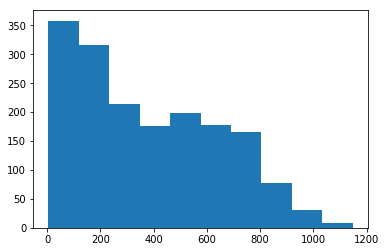

In [279]:
from wordgen import *
wg = WordgenLearned(3,"ind-Latn")

ipa_chars = wg.load_ipa_chars('eng-Latn')

dists = []
for c1 in ipa_chars:
    for c2 in ipa_chars:
        s1,s2 = to_panphon_fts(c1),to_panphon_fts(c2)
        assert(len(s1)==1)
        assert(len(s2)==1)
        s1,s2 = s1[0],s2[0]
        if c1 != c2 : dists.append(dist(s1,s2))
max_dist,min_dist = max(dists),min(dists)
print(max_dist,min_dist)
plt.hist(dists)
plt.show()

In [282]:
ipa_chars = list(wg.load_ipa_chars('eng-Latn')) # now this is an ordered list, kind of serving as an enumeration
num_chars = len(ipa_chars)
projection = [n for n in range(num_chars)] # we start with identity mapping and will gradually identify things
# think of projection as mapping from indices representing ipa_chars to equivalence classes
# the number of equivalence classes is len(set(projection))
M = 30
step_size = (max_dist-min_dist)/float((len(ipa_chars)-M)*500)
spread = step_size/2.
for r0 in np.arange(min_dist,max_dist,step_size):
    r = np.random.normal(r0,spread)
    ipa_char_index = np.random.randint(num_chars)
    s0 = to_panphon_fts(ipa_chars[ipa_char_index])
    assert(len(s0)==1)
    s0 = s0[0]
    for n in range(num_chars):
        s = to_panphon_fts(ipa_chars[n])
        assert(len(s)==1)
        s = s[0]
        if dist(s,s0)<r:
            projection[n]=projection[ipa_char_index]
    if len(set(projection))<=M: break

In [283]:
for p in set(projection):
    print([ipa_chars[n] for n in range(num_chars) if projection[n]==p])

['t']
['v']
['d͡ʒ']
['ə', 'e']
['n̩', 'ʒ']
['ɹ', 'j']
['d', 's']
['ɪ']
['t͡ʃ']
['m']
['l', 'ʃ', 'n']
['u']
['ð']
['b']
['ɡ']
['z']
['a', 'ʊ', 'ɑ']
['ɾ', 'h']
['o']
['ɹ̩']
['i']
['k', 'ʔ']
['ɛ']
['m̩']
['p']
['ŋ']
['f']
['ɔ', 'æ', 'ʌ']
['θ']
['w']
